# ANLI with LLM

You have to implement in this notebook a better ANLI classifier using an LLM.
This classifier must be implemented using DSPy.


In [ ]:
# Configure the DSPy environment with the language model - for grok the parameters must be:
# env variable should be in os.environ['XAI_API_KEY']
# "xai/grok-3-mini"
import os
import dspy
from typing import Literal
from datasets import load_dataset
from sentence_transformers import SentenceTransformer
import evaluate
import numpy as np
from tqdm.auto import tqdm


os.environ["XAI_API_KEY"] = ""

lm = dspy.LM('xai/grok-3-mini', api_key=os.environ['XAI_API_KEY'])
dspy.configure(lm=lm)

## Load ANLI dataset

In [38]:
dataset = load_dataset("facebook/anli")
dataset = dataset.filter(lambda x: x['reason'] != None and x['reason'] != "")

## Evaluate Metrics

Let's use the huggingface `evaluate` package to compute the performance of the baseline.


In [39]:
from evaluate import load

accuracy = load("accuracy")
precision = load("precision")
recall = load("recall")
f1 = load("f1")


In [5]:
import evaluate
clf_metrics = evaluate.combine(["accuracy", "f1", "precision", "recall"])

## Your Turn

Compute the classification metrics on the baseline LLM model on each test section of the ANLI dataset for samples that have a non-empty 'reason' field.

You also must show a comparison between the DeBERTa baseline model and this LLM baseline model. The comparison metric should compute the agreement between the two models:
* On how many samples they are both correct [Correct]
* On how many samples Model1 is correct and Model2 is incorrect [Correct1]
* On how many samples Model1 is incorrect and Model2 is correct [Correct2]
* On how many samples both are incorrect [Incorrect]

In [52]:
## Task 1.4: Explanation CoT LLM for ANLI

### Step 1: Implement DSPy Signatures and Modules

# Define the signatures for both strategies
class JointPromptSignature(dspy.Signature):
    """Generate both an explanation and a label for the NLI task in one step."""
    premise = dspy.InputField()
    hypothesis = dspy.InputField()
    explanation = dspy.OutputField(desc="Explanation of the relationship between premise and hypothesis.")  
    label: Literal['entailment', 'neutral', 'contradiction'] = dspy.OutputField()

class PipelineExplanationSignature(dspy.Signature):
    """Generate an explanation for the relationship between premise and hypothesis."""
    premise = dspy.InputField()
    hypothesis = dspy.InputField()
    explanation = dspy.OutputField(desc="Explanation of the relationship between premise and hypothesis.")  

class PipelineResponseSignature(dspy.Signature):
    """Given an explanation, determine the entailment label."""
    premise = dspy.InputField()
    hypothesis = dspy.InputField()
    explanation = dspy.InputField(desc="Explanation of the relationship between premise and hypothesis.")
    label: Literal['entailment', 'neutral', 'contradiction'] = dspy.OutputField()

# Pipeline approach
class PipelineModule(dspy.Module):
    def __init__(self):
        super().__init__()
        self.explanation_step = dspy.ChainOfThought(PipelineExplanationSignature)
        self.label_step = dspy.Predict(PipelineResponseSignature)
    
    def forward(self, premise, hypothesis):
        explanation_result = self.explanation_step(
            premise=premise, 
            hypothesis=hypothesis 
        )
        label_result = self.label_step(premise=premise, hypothesis=hypothesis, explanation=explanation_result.explanation)

        return dspy.Prediction(
            explanation=explanation_result.explanation,
            label=label_result.label
        )

# Initialize modules
print("Initializing modules...")
joint_cot = dspy.ChainOfThought(JointPromptSignature)
pipeline_module = PipelineModule()
print("✓ Modules initialized")



Initializing modules...
✓ Modules initialized


In [53]:
### Step 2: Utility Functions for Similarity Analysis

def compute_similarity_scores(premise, hypothesis, human_reason, predicted_explanation, similarity_model):
    """
    Compute similarity scores between different text combinations.
    Returns a dictionary with all possible combinations.
    """
    # Combine premise and hypothesis
    premise_hypothesis = f"{premise} {hypothesis}"
    
    # Encode all texts
    texts = [premise_hypothesis, human_reason, predicted_explanation]
    embeddings = similarity_model.encode(texts)
    
    # Compute similarities
    similarities = similarity_model.similarity(embeddings, embeddings).numpy()
    
    # Extract individual similarities
    ph_hr_sim = similarities[0, 1]  # premise+hypothesis vs human_reason
    ph_pe_sim = similarities[0, 2]  # premise+hypothesis vs predicted_explanation
    hr_pe_sim = similarities[1, 2]  # human_reason vs predicted_explanation
    
    # Handle division by zero
    def safe_divide(a, b):
        return a / b if b != 0 else 0
    
    return {
        'A': ph_hr_sim,  # (premise, hypothesis) vs human_reason
        'B': hr_pe_sim,  # human_reason vs predicted_explanation
        'C': ph_pe_sim,  # (premise, hypothesis) vs predicted_explanation
        'A/B': safe_divide(ph_hr_sim, hr_pe_sim),
        'A/C': safe_divide(ph_hr_sim, ph_pe_sim),
        'B/C': safe_divide(hr_pe_sim, ph_pe_sim)
    }



In [59]:
### Step 3: Evaluation Function

def evaluate_with_similarity(module, dataset, similarity_model, collect_results=False):
    """
    Evaluate a module on the dataset and optionally collect detailed results.
    """

    LABEL_MAP = {'entailment': 0, 'neutral': 1, 'contradiction': 2}

    correct = 0
    total = 0
    results = []
    
    for example in tqdm(dataset, desc="Evaluating"):
        # Skip examples without human reason
        if not example.get('reason') or example['reason'].strip() == '':
            continue
            
        try:
            # Get prediction
            prediction = module(
                premise=example['premise'],
                hypothesis=example['hypothesis']
            )

            pred_label_str = prediction.label.lower().strip()
            pred_label_int = LABEL_MAP.get(pred_label_str, -1)

            # Check if prediction is correct
            is_correct = pred_label_int == example['label']

            if is_correct:
                correct += 1
            total += 1
            
            # Collect detailed results if requested
            if collect_results:
                # Compute similarity scores
                sim_scores = compute_similarity_scores(
                    premise=example['premise'],
                    hypothesis=example['hypothesis'],
                    human_reason=example['reason'],
                    predicted_explanation=prediction.explanation,
                    similarity_model=similarity_model
                )
                
                results.append({
                    'premise': example['premise'],
                    'hypothesis': example['hypothesis'],
                    'true_label': example['label'],
                    'predicted_label': prediction.label,
                    'human_reason': example['reason'],
                    'predicted_explanation': prediction.explanation,
                    'is_correct': is_correct,
                    **sim_scores  # Add all similarity scores
                })
                
        except Exception as e:
            print(f"Error processing example: {e}")
            continue
    
    accuracy = correct / total if total > 0 else 0
    return accuracy, results



In [ ]:
from typing import List, Dict, Any

def create_dspy_examples(dataset: List[Dict[str, Any]]) -> List[dspy.Example]:
    """
    Convert dataset to dspy.Example instances including the 'reason' field.
    The 'reason' field will be stored in the example but won't be visible to the LLM
    since it's not included in the signatures.
    """
    examples = []
    for item in dataset:
        if item.get('reason') and item['reason'].strip() != '':
            # Create dspy.Example with all fields including 'reason'
            example = dspy.Example(
                premise=item['premise'],
                hypothesis=item['hypothesis'],
                label=item['label'],
                reason=item['reason']  # This field is stored but not in signatures
            )
            examples.append(example)
    return examples



In [48]:
# Load evaluation dataset (using dev_r3 for testing)
print("Loading dev_r3 dataset...")
dev_dataset = load_dataset("anli", split="dev_r3")
# Filter examples with reasons
dev_with_reasons = [ex for ex in dev_dataset if ex.get('reason') and ex['reason'].strip() != '']
print(f"Found {len(dev_with_reasons)} examples with reasons out of {len(dev_dataset)} total")

Loading dev_r3 dataset...
Found 1200 examples with reasons out of 1200 total


In [81]:
### DSPy Evaluate Setup

# Create evaluation metric function for DSPy
def nli_metric(example, prediction, trace=None):
    """Metric function for DSPy evaluation."""
    return prediction.label == example.label

# Sample for evaluation (adjust size as needed)
eval_samples = dev_with_reasons[:200]  # Use 200 samples for evaluation

# Convert your evaluation samples to dspy.Example instances
dspy_eval_samples = create_dspy_examples(eval_samples)

# Initialize similarity model
from sentence_transformers import SentenceTransformer
similarity_model = SentenceTransformer("all-MiniLM-L6-v2")

In [67]:
# Evaluate Joint CoT approach
print("\nEvaluating Joint CoT approach...")
joint_accuracy, joint_results = evaluate_with_similarity(
    joint_cot, 
    eval_samples, 
    similarity_model,
    collect_results=True
)
print(f"Joint CoT Accuracy: {joint_accuracy:.3f}")



Evaluating Joint CoT approach...


Evaluating:   0%|          | 0/200 [00:00<?, ?it/s]

Joint CoT Accuracy: 0.735


In [68]:
# Evaluate Pipeline approach
print("\nEvaluating Pipeline approach...")
pipeline_accuracy, pipeline_results = evaluate_with_similarity(
    pipeline_module,
    eval_samples,
    similarity_model,
    collect_results=True
)
print(f"Pipeline Accuracy: {pipeline_accuracy:.3f}")


Evaluating Pipeline approach...


Evaluating:   0%|          | 0/200 [00:00<?, ?it/s]

Pipeline Accuracy: 0.745


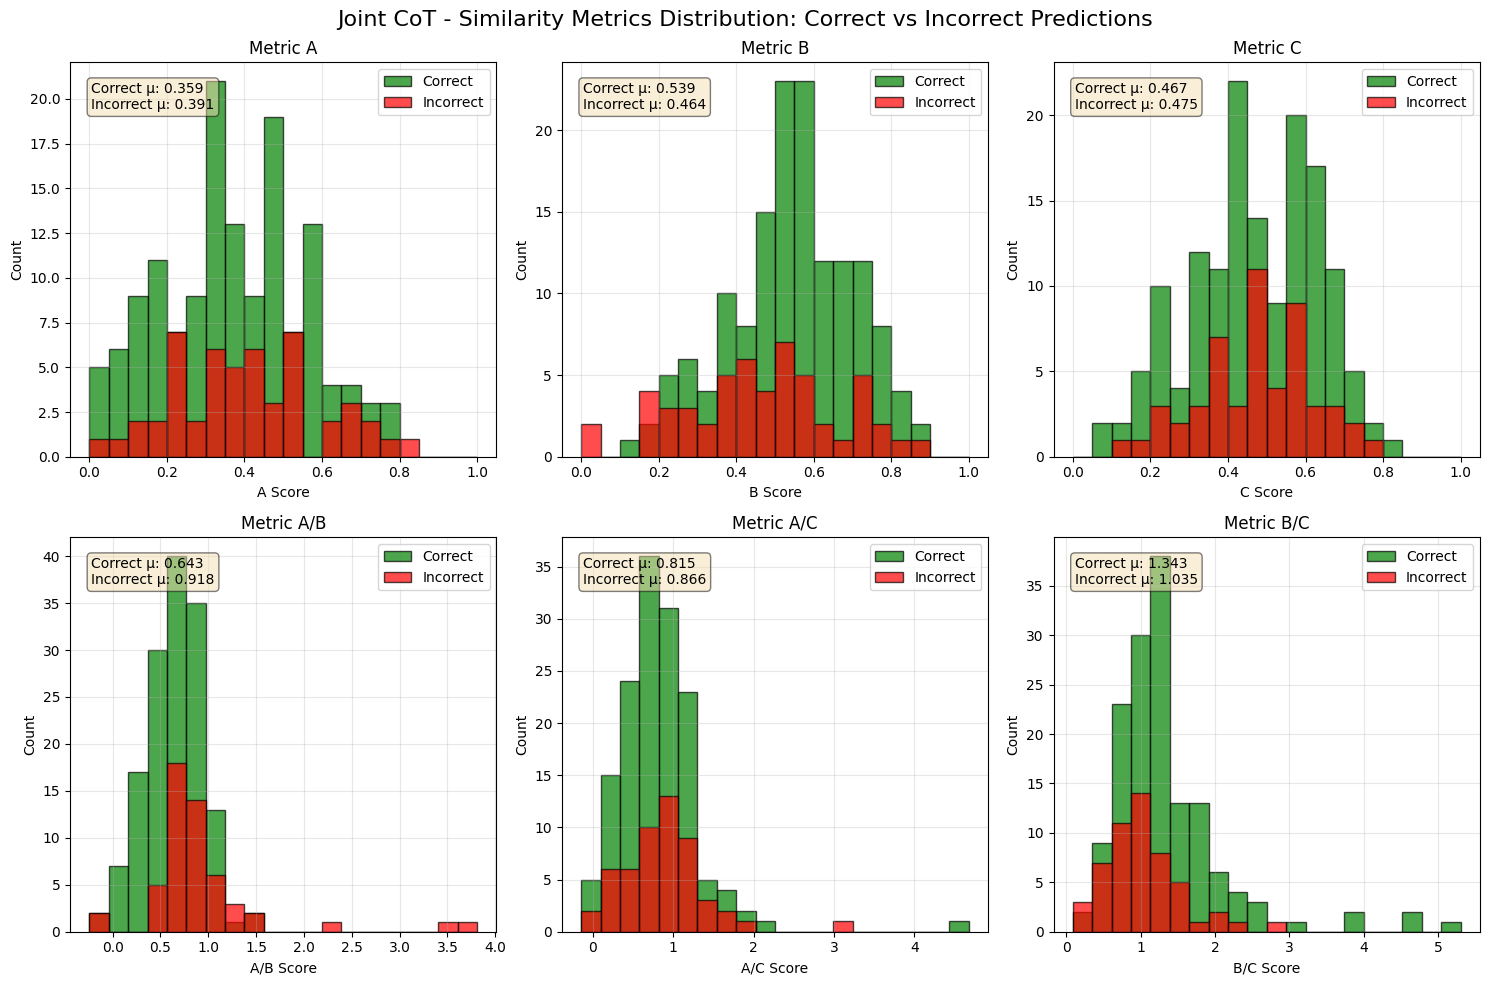

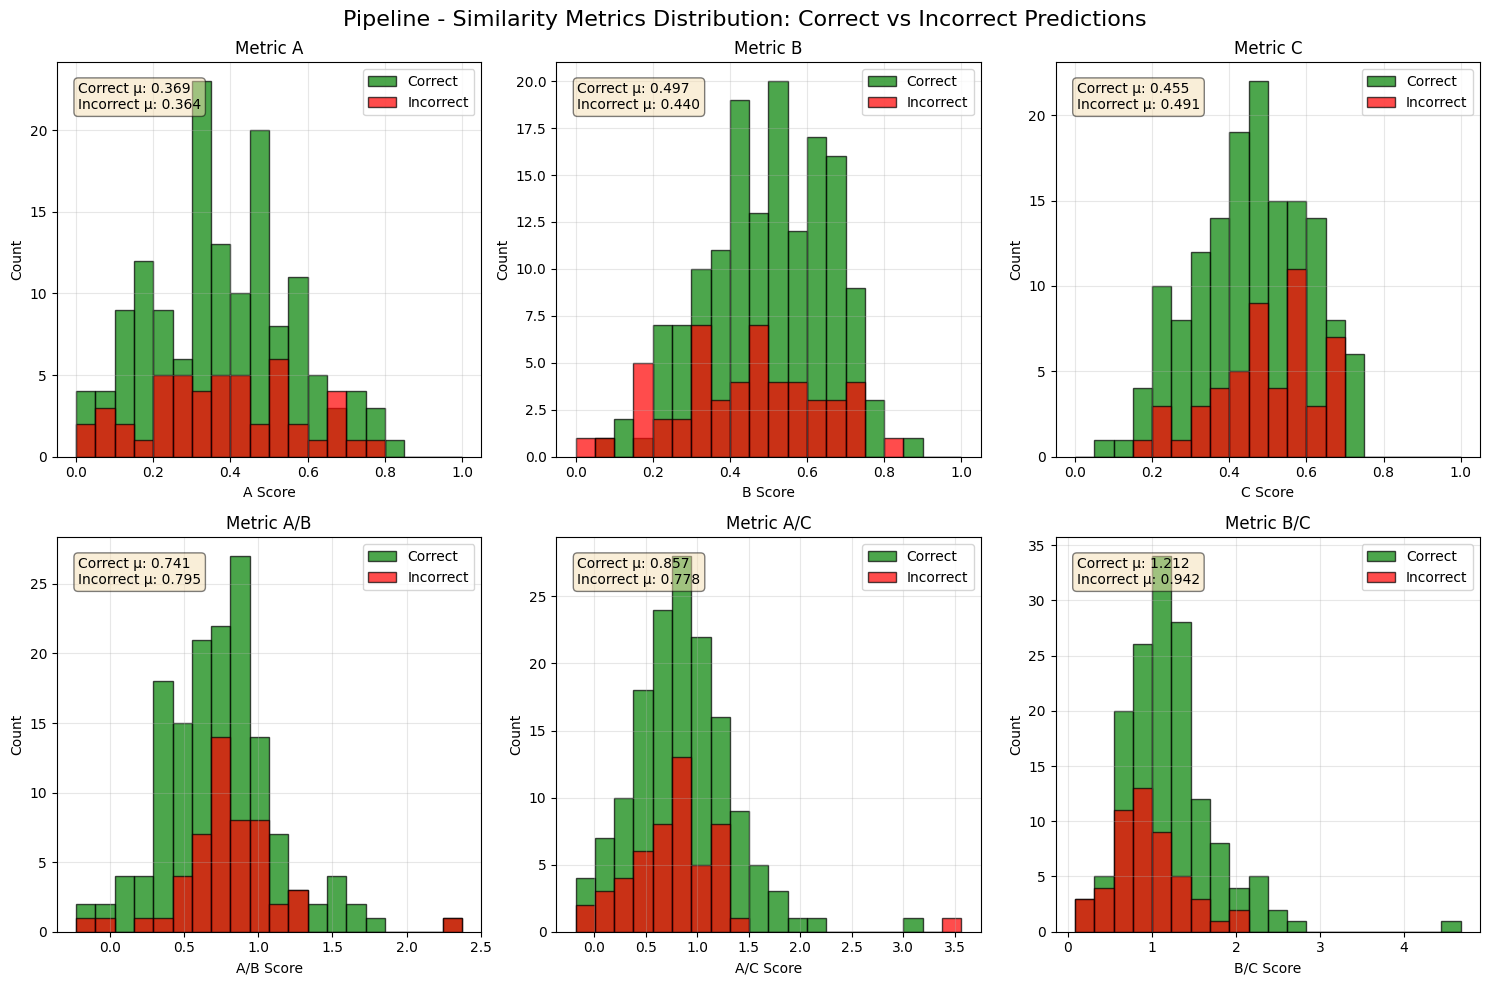

In [70]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

def create_similarity_histograms(results, approach_name):
    """
    Create histograms for each similarity metric comparing correct vs incorrect predictions.
    """
    # Convert results to DataFrame for easier analysis
    df = pd.DataFrame(results)
    
    # Separate correct and incorrect predictions
    correct_df = df[df['is_correct'] == True]
    incorrect_df = df[df['is_correct'] == False]
    
    # Define metrics to plot
    metrics = ['A', 'B', 'C', 'A/B', 'A/C', 'B/C']
    
    # Create subplots
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    fig.suptitle(f'{approach_name} - Similarity Metrics Distribution: Correct vs Incorrect Predictions', fontsize=16)
    axes = axes.flatten()
    
    for idx, metric in enumerate(metrics):
        ax = axes[idx]
        
        # Get data for correct and incorrect predictions
        correct_values = correct_df[metric].values
        incorrect_values = incorrect_df[metric].values
        
        # Determine range for histogram bins
        all_values = np.concatenate([correct_values, incorrect_values])
        min_val, max_val = np.min(all_values), np.max(all_values)
        
        # Create bins
        if metric in ['A', 'B', 'C']:  # Similarity scores are between 0 and 1
            bins = np.linspace(0, 1, 21)  # 20 bins from 0 to 1
        else:  # Ratio metrics can have wider range
            bins = np.linspace(min_val, max_val, 21)
        
        # Plot histograms
        ax.hist(correct_values, bins=bins, alpha=0.7, label='Correct', color='green', edgecolor='black')
        ax.hist(incorrect_values, bins=bins, alpha=0.7, label='Incorrect', color='red', edgecolor='black')
        
        # Add labels and title
        ax.set_xlabel(f'{metric} Score')
        ax.set_ylabel('Count')
        ax.set_title(f'Metric {metric}')
        ax.legend()
        ax.grid(True, alpha=0.3)
        
        # Add statistics
        correct_mean = np.mean(correct_values) if len(correct_values) > 0 else 0
        incorrect_mean = np.mean(incorrect_values) if len(incorrect_values) > 0 else 0
        ax.text(0.05, 0.95, f'Correct μ: {correct_mean:.3f}\nIncorrect μ: {incorrect_mean:.3f}', 
                transform=ax.transAxes, verticalalignment='top',
                bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
    
    plt.tight_layout()
    return fig


# Create histograms for both approaches
joint_fig = create_similarity_histograms(joint_results, "Joint CoT")
plt.show()

pipeline_fig = create_similarity_histograms(pipeline_results, "Pipeline")
plt.show()


### Observations 

#### Probable Ranges of Scores for Correct Label:

##### Joint CoT:

Metric A: 0.0 - 0.6 

Metric B: 0.45 - 0.85

Metric A/B: 0.0 - 1.25

Metric A/C: 0.0 - 1.25


##### Pipeline:

Metric A: 0.1 - 0.85

Metric B: 0.2 - 0.8

Metric A/B: 0.0 - 1.9

Metric B/C: over 0.5


In [82]:
def joint_similarity_reward(example: dspy.Example, pred: dspy.Prediction) -> float:

    reason = example.get('reason', '')
    score = 0
    similarity_scores = compute_similarity_scores(
        example.premise, 
        example.hypothesis, 
        reason, 
        pred.explanation, 
        similarity_model
    )
    
    if 0.0 <= similarity_scores['A'] <= 0.6:
        score += 1
    if 0.45 <= similarity_scores['B'] <= 0.85:
        score += 1
    if 0.0 <= similarity_scores['A/B'] <= 1.25:
        score += 1
    if 0.0 <= similarity_scores['A/C'] <= 1.25:
        score += 1
    
    return score

def pipeline_similarity_reward(example: dspy.Example, pred: dspy.Prediction) -> float:

    reason = example.get('reason', '')
    score = 0
    similarity_scores = compute_similarity_scores(
        example.premise, 
        example.hypothesis, 
        reason, 
        pred.explanation, 
        similarity_model
    )
    
    if 0.1 <= similarity_scores['A'] <= 0.85:
        score += 1
    if 0.2 <= similarity_scores['B'] <= 0.8:
        score += 1
    if 0.0 <= similarity_scores['A/B'] <= 1.9:
        score += 1
    if 0.5 <= similarity_scores['B/C']:
        score += 1
    
    return score


refined_joint = dspy.Refine(
    module=joint_cot, 
    N=5, 
    reward_fn=joint_similarity_reward, 
    threshold=3.0
)

refined_pipeline = dspy.Refine(
    module=pipeline_module, 
    N=5, 
    reward_fn=pipeline_similarity_reward, 
    threshold=3.0
)

In [83]:
joint_accuracy, joint_results = evaluate_with_similarity(
    refined_joint, 
    dspy_eval_samples[:10], 
    similarity_model,
    collect_results=True
)
print(f"Joint CoT Accuracy: {joint_accuracy:.3f}")


Evaluating:   0%|          | 0/10 [00:00<?, ?it/s]

Refine: Attempt failed with temperature 0.0: 'dict' object has no attribute 'premise'
Refine: Attempt failed with temperature 0.5: 'dict' object has no attribute 'premise'
Refine: Attempt failed with temperature 0.6: 'dict' object has no attribute 'premise'
Refine: Attempt failed with temperature 0.7: 'dict' object has no attribute 'premise'
Error processing example: 'dict' object has no attribute 'premise'
Refine: Attempt failed with temperature 0.0: 'dict' object has no attribute 'premise'
Refine: Attempt failed with temperature 0.5: 'dict' object has no attribute 'premise'
Refine: Attempt failed with temperature 0.6: 'dict' object has no attribute 'premise'
Error processing example: 'dict' object has no attribute 'premise'
Refine: Attempt failed with temperature 0.0: 'dict' object has no attribute 'premise'
Refine: Attempt failed with temperature 0.5: 'dict' object has no attribute 'premise'
Error processing example: 'dict' object has no attribute 'premise'
Refine: Attempt failed wi